# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import imageio
imageio.plugins.ffmpeg.download()

%matplotlib inline


## Read in an Image

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.show()

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, c)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [125]:
import os
import math
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

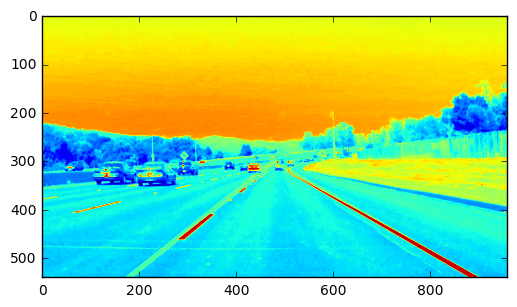

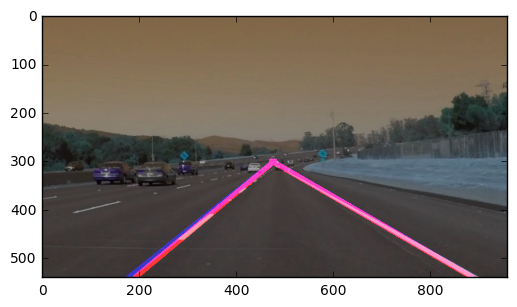

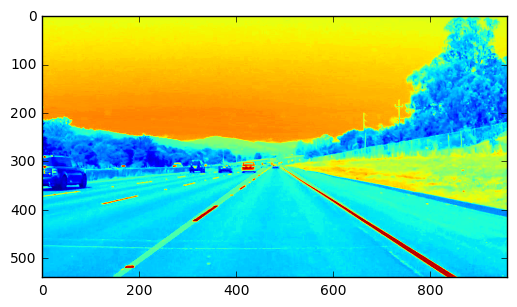

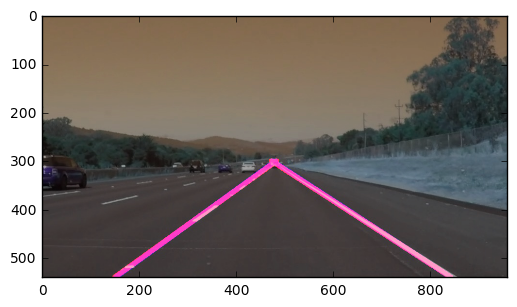

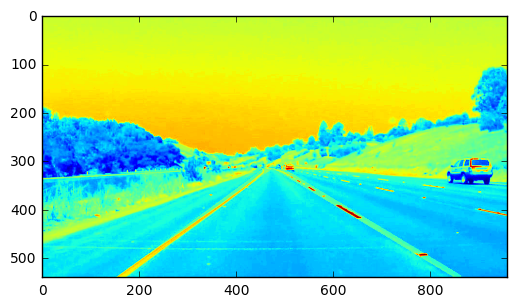

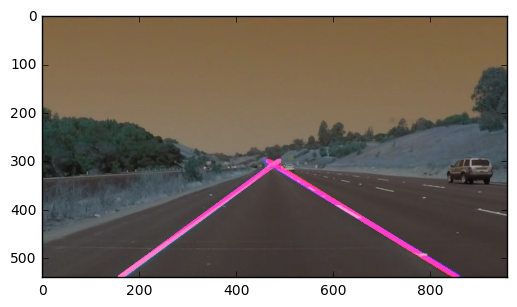

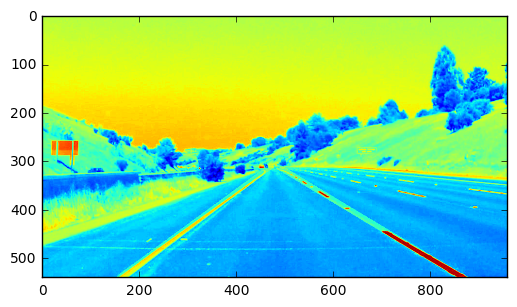

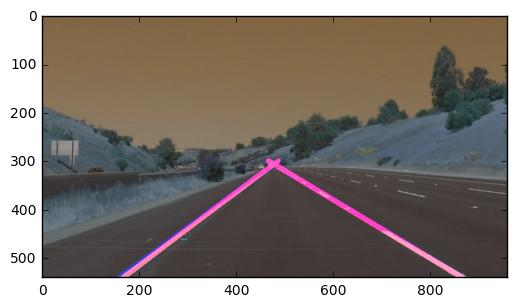

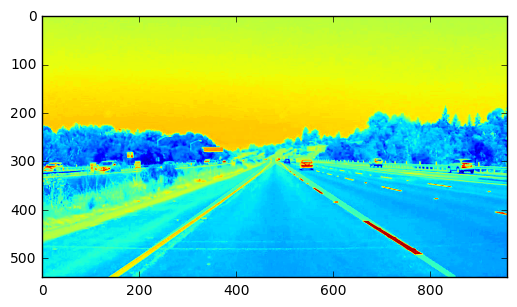

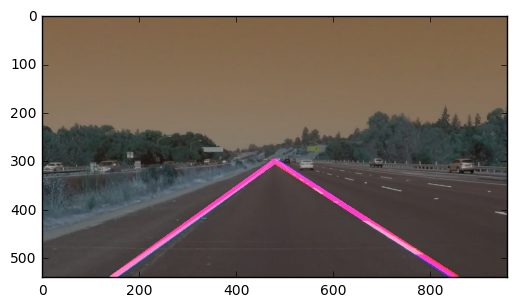

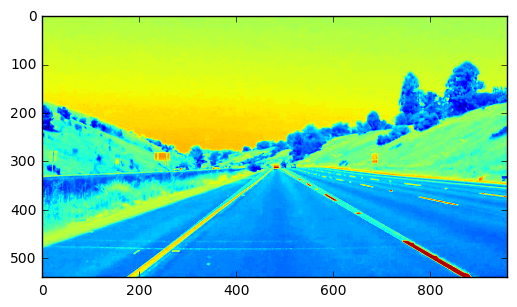

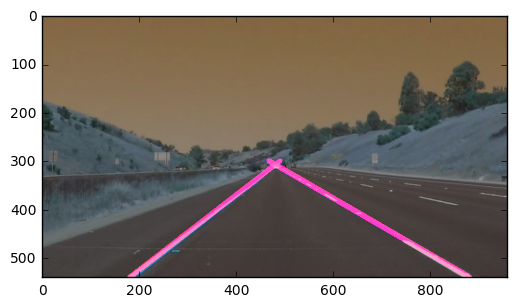

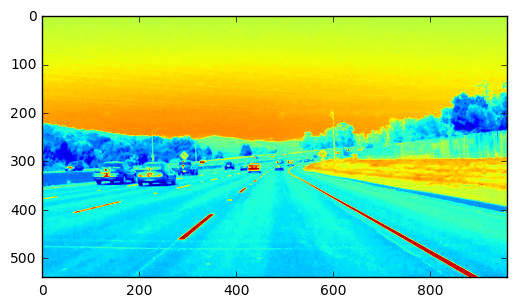

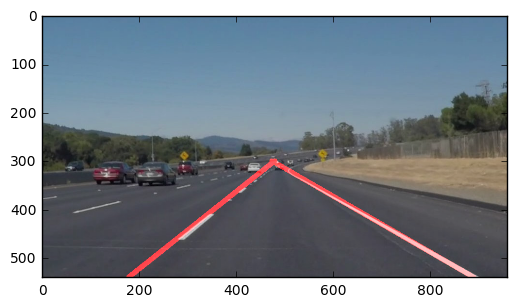

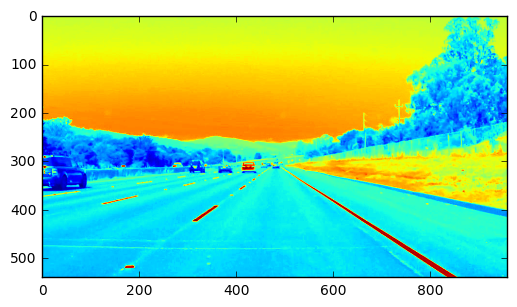

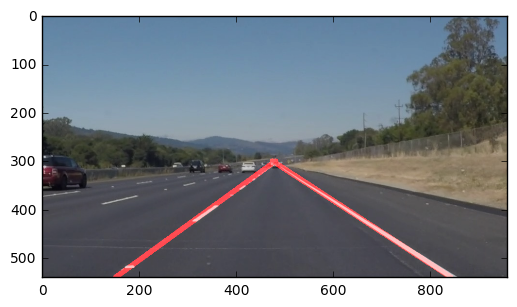

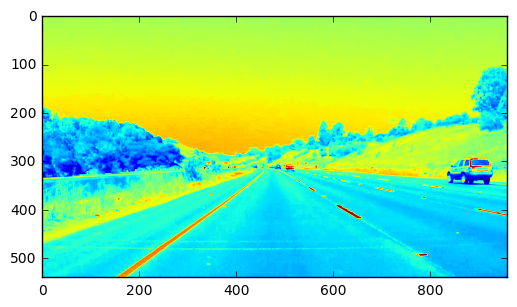

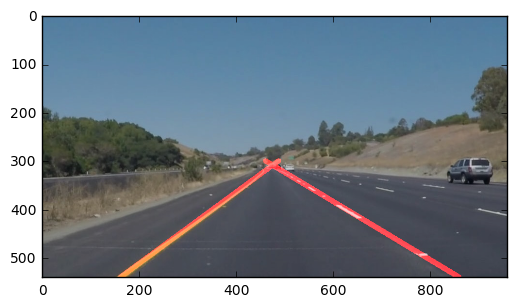

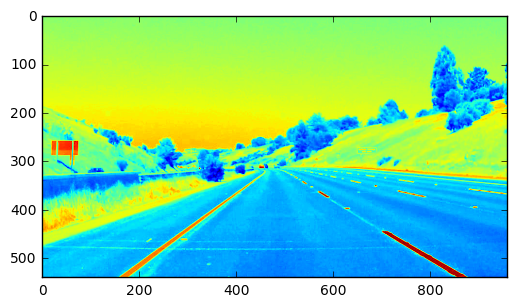

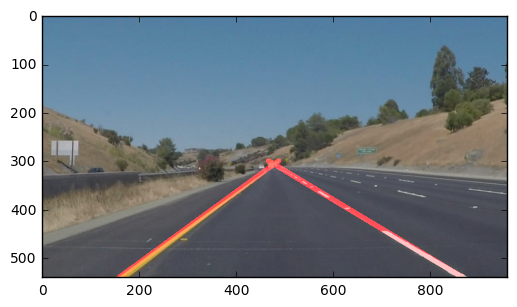

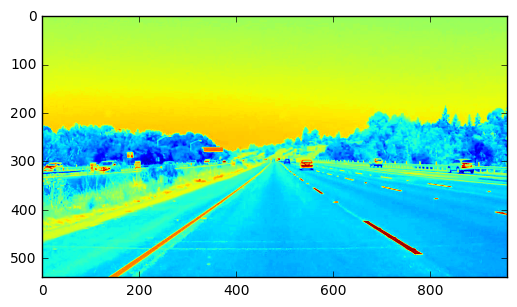

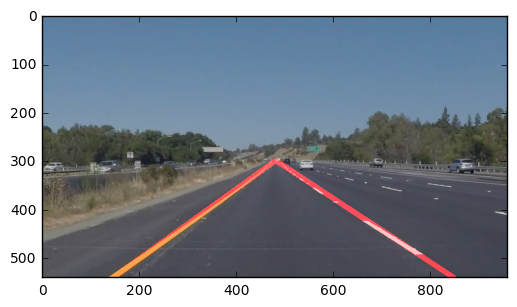

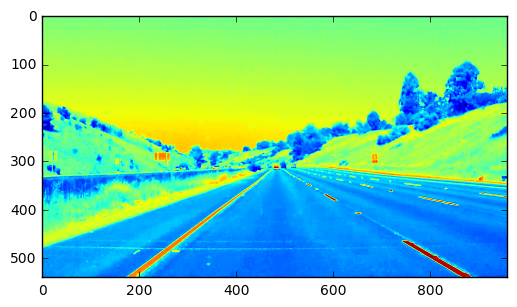

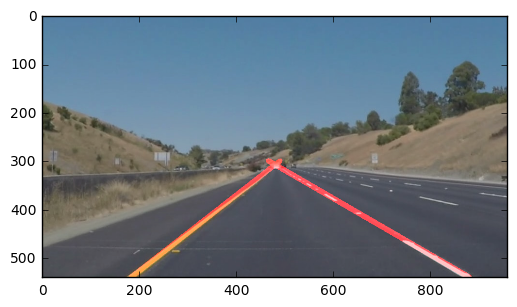

In [152]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# starting with the code

# read input image and display them
for filename in os.listdir("test_images/"):
    #print "\\test_images\\"+filename
    image = mpimg.imread("test_images/"+filename)
#image = mpimg.imread("test_images/solidYellowLeft.jpg")
     # convert to grayscale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray_image)
    plt.show()
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray_image,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 150
    high_threshold = 200
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    #perform Canny edge detection on the grayscale image
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    
    vertices = np.array([[(50,imshape[0]),(450, 300), (500, 300), (imshape[1],imshape[0])]], dtype=np.int32)

    #print(vertices)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # arrays to store the values of the left and the right lines
    left_arr = [];
    right_arr = [];

    for line in lines:        
        for temp in line:
            slope = (float(temp[3])-float(temp[1]))/(float(temp[2])-float(temp[0]))
            if math.isnan(slope):
                continue
            # if the slope is negative , the points belong to the left lane
            if slope < 0:
                left_arr.append(temp)
                #if the slope is positive or zero, the points belong to the right lane
            elif slope >= 0:
                right_arr.append(temp)
            avg_left_line = np.average(left_arr, axis=0)
            avg_right_line = np.average(right_arr, axis=0)
           
#for x1, y1, x2, y2 in avg_left_line:
#cv2.line(line_image,(int(avg_left_line[0]),int(avg_left_line[1])),(int(avg_left_line[2]),int(avg_left_line[3])),(255,0,0),10)
#for x1, y1, x2, y2 in avg_right_line:
#cv2.line(line_image,(int(avg_right_line[0]),int(avg_right_line[1])),(int(avg_right_line[2]),int(avg_right_line[3])),(255,0,0),10)

    # get slope and intercept for left lane
    m = (float(avg_left_line[3]) - float(avg_left_line[1]))/(float(avg_left_line[2])-float(avg_left_line[0]))
    intercept = avg_left_line[3] - m * avg_left_line[2]

    #find the starting x co-ordinates for the left lane. The Y- cordinates have been used from ROI
    x1 = float(imshape[0] - intercept)/m
    x2 = float(300 - intercept)/m
    # draw the left lane
    cv2.line(line_image,(int(x1),imshape[0]),(int(x2-7),300),(255,0,0),10)

    # get slope and intercept for right lane
    m = (float(avg_right_line[3]) - float(avg_right_line[1]))/(float(avg_right_line[2])-float(avg_right_line[0]))
    intercept = avg_right_line[3] - m * avg_right_line[2]

    #find the starting x co-ordinates for the right lane. The Y co-ordinates have been used from the ROI
    x1 = float(imshape[0] - intercept)/m
    x2 = float(300 - intercept)/m
    # draw the right lane
    cv2.line(line_image,(int(x1),imshape[0]),(int(x2+7),300),(255,0,0),10)
 
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    #lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    plt.imshow(lines_edges)
    plt.show()
 
    cv2.imwrite("test_images/" + "copy_" + filename,lines_edges)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [146]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    #  # convert to grayscale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
 
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray_image,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    #perform Canny edge detection on the grayscale image
    low_threshold = 150
    high_threshold = 200
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(450, 300), (500, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
 

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    # Iterate over the output "lines" and differentiate between the left and right lanes
    left_arr = [];
    right_arr = [];
    #print lines
    for line in lines:
    #    print line    
        for temp in line:
            slope = (float(temp[3])-float(temp[1]))/(float(temp[2])-float(temp[0]))
            # if slope is negative, the values belong to the left side of the lane
            if slope < 0:
                left_arr.append(temp)
            #if the slope is greater than or equal to 0, the values belong to the right side of the lane
            elif slope >= 0:
                right_arr.append(temp)
    
    # take the average of the left lane 
    avg_left_line = np.average(left_arr, axis=0)
    
    # store the average values calculated in each frame for the left side so that each subsequent frame can be used to calculate
    #its average
    average_left_prev.append(avg_left_line)
    
    # take the average of the right lane
    avg_right_line = np.average(right_arr, axis=0)
    # store the average values calculated in each frame for the right side so that each subsequent frame can be used to calculate
    #its average
    average_right_prev.append(avg_right_line)
    
    # use the last 50 values from the buffer to get the average for the left and right side.
    # the value 50 has been obtained after experiementation
    new_left_avg = np.average(average_left_prev[-50:], axis=0)
    new_right_avg = np.average(average_right_prev[-50:], axis=0)
    
       
    # get slope and intercept for left lane
    
    m = (float(new_left_avg[3]) - float(new_left_avg[1]))/(float(new_left_avg[2]-float(new_left_avg[0])))
    
    intercept = new_left_avg[3] - m * new_left_avg[2]
    x1 = float(imshape[0] - intercept)/m
    
    #the value of 300 for the Y co-ordinate has been obtained after experimentation
    x2 = float(300 - intercept)/m
    # A value of 15 is deducted from the x co-ordinate to align the ROI. This value was obtained
    # by hit and trial to get the best fit
    cv2.line(line_image,(int(x1),imshape[0]),(int(x2-15),300),(255,0,0),10)
    

    
    # get slope and intercept for right lane
    #m = (float(avg_right_line[3]) - float(avg_right_line[1]))/(float(avg_right_line[2]-float(avg_right_line[0])))

    m = (float(new_right_avg[3]) - float(new_right_avg[1]))/(float(new_right_avg[2]-float(new_right_avg[0])))
    
    intercept = new_right_avg[3] - m * new_right_avg[2]

    #find the starting x co-ordinates
    x1 = float(imshape[0] - intercept)/m
    x2 = float(300 - intercept)/m
    # A value of 15 is deducted from the x co-ordinate to align the ROI. This value was obtained
    # by hit and trial to get the best fit
    cv2.line(line_image,(int(x1),imshape[0]),(int(x2+15),300),(255,0,0),10)
    
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the original image
    result = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
   
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [147]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
average_left_prev = []
average_right_prev = []
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

1
1
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

2
2


  0%|▎                                                                                 | 1/222 [00:00<00:55,  3.97it/s]

3
3
4
4
5
5


  2%|█▍                                                                                | 4/222 [00:00<00:40,  5.35it/s]

6
6
7
7
8
8
9
9


  4%|██▉                                                                               | 8/222 [00:00<00:30,  7.11it/s]

10
10
11
11
12
12


  5%|████                                                                             | 11/222 [00:00<00:23,  9.03it/s]

13
13
14
14
15
15


  6%|█████                                                                            | 14/222 [00:00<00:18, 11.28it/s]

16
16
17
17
18
18
19
19


  8%|██████▌                                                                          | 18/222 [00:00<00:14, 13.84it/s]

20
20
21
21
22
22


  9%|███████▋                                                                         | 21/222 [00:00<00:12, 15.93it/s]

23
23
24
24
25
25


 11%|████████▊                                                                        | 24/222 [00:01<00:11, 17.62it/s]

26
26
27
27
28
28


 12%|█████████▊                                                                       | 27/222 [00:01<00:10, 19.15it/s]

29
29
30
30
31
31


 14%|██████████▉                                                                      | 30/222 [00:01<00:09, 20.77it/s]

32
32
33
33
34
34


 15%|████████████                                                                     | 33/222 [00:01<00:08, 22.72it/s]

35
35
36
36
37
37


 16%|█████████████▏                                                                   | 36/222 [00:01<00:07, 24.39it/s]

38
38
39
39
40
40


 18%|██████████████▏                                                                  | 39/222 [00:01<00:07, 24.94it/s]

41
41
42
42
43
43


 19%|███████████████▎                                                                 | 42/222 [00:01<00:07, 24.95it/s]

44
44
45
45
46
46


 20%|████████████████▍                                                                | 45/222 [00:01<00:07, 24.30it/s]

47
47
48
48
49
49


 22%|█████████████████▌                                                               | 48/222 [00:02<00:09, 17.79it/s]

50
50
51
51
52
52


 23%|██████████████████▌                                                              | 51/222 [00:02<00:08, 19.94it/s]

53
53
54
54
55
55


 24%|███████████████████▋                                                             | 54/222 [00:02<00:08, 19.42it/s]

56
56
57
57
58
58


 26%|████████████████████▊                                                            | 57/222 [00:02<00:07, 20.85it/s]

59
59
60
60
61
61


 27%|█████████████████████▉                                                           | 60/222 [00:02<00:07, 22.75it/s]

62
62
63
63
64
64


 28%|██████████████████████▉                                                          | 63/222 [00:02<00:07, 21.70it/s]

65
65
66
66
67
67


 30%|████████████████████████                                                         | 66/222 [00:02<00:06, 22.60it/s]

68
68
69
69
70
70


 31%|█████████████████████████▏                                                       | 69/222 [00:03<00:06, 22.09it/s]

71
71
72
72
73
73


 32%|██████████████████████████▎                                                      | 72/222 [00:03<00:06, 22.83it/s]

74
74
75
75
76
76


 34%|███████████████████████████▎                                                     | 75/222 [00:03<00:06, 21.53it/s]

77
77
78
78
79
79


 35%|████████████████████████████▍                                                    | 78/222 [00:03<00:06, 23.41it/s]

80
80
81
81
82
82


 36%|█████████████████████████████▌                                                   | 81/222 [00:03<00:06, 22.93it/s]

83
83
84
84
85
85


 38%|██████████████████████████████▋                                                  | 84/222 [00:03<00:05, 23.46it/s]

86
86
87
87
88
88


 39%|███████████████████████████████▋                                                 | 87/222 [00:03<00:05, 24.08it/s]

89
89
90
90
91
91


 41%|████████████████████████████████▊                                                | 90/222 [00:04<00:05, 22.95it/s]

92
92
93
93
94
94


 42%|█████████████████████████████████▉                                               | 93/222 [00:04<00:05, 24.15it/s]

95
95
96
96
97
97


 43%|███████████████████████████████████                                              | 96/222 [00:04<00:05, 22.74it/s]

98
98
99
99
100
100


 45%|████████████████████████████████████                                             | 99/222 [00:04<00:05, 23.54it/s]

101
101
102
102
103
103


 46%|████████████████████████████████████▊                                           | 102/222 [00:04<00:05, 23.62it/s]

104
104
105
105
106
106


 47%|█████████████████████████████████████▊                                          | 105/222 [00:04<00:04, 25.16it/s]

107
107
108
108
109
109


 49%|██████████████████████████████████████▉                                         | 108/222 [00:05<00:08, 13.28it/s]

110
110
111
111
112
112
113
113


 50%|████████████████████████████████████████▎                                       | 112/222 [00:05<00:07, 15.65it/s]

114
114
115
115
116
116


 52%|█████████████████████████████████████████▍                                      | 115/222 [00:05<00:06, 17.47it/s]

117
117
118
118
119
119


 53%|██████████████████████████████████████████▌                                     | 118/222 [00:05<00:05, 17.97it/s]

120
120
121
121
122
122


 55%|███████████████████████████████████████████▌                                    | 121/222 [00:06<00:08, 11.34it/s]

123
123
124
124
125
125


 56%|████████████████████████████████████████████▋                                   | 124/222 [00:06<00:07, 13.85it/s]

126
126
127
127
128
128


 57%|█████████████████████████████████████████████▊                                  | 127/222 [00:06<00:06, 14.91it/s]

129
129
130
130
131
131


 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:06<00:05, 17.26it/s]

132
132
133
133
134
134


 60%|███████████████████████████████████████████████▉                                | 133/222 [00:06<00:05, 17.44it/s]

135
135
136
136
137
137


 61%|█████████████████████████████████████████████████                               | 136/222 [00:06<00:04, 18.57it/s]

138
138
139
139
140
140


 63%|██████████████████████████████████████████████████                              | 139/222 [00:06<00:04, 19.73it/s]

141
141
142
142
143
143


 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:06<00:04, 19.24it/s]

144
144
145
145
146
146


 65%|████████████████████████████████████████████████████▎                           | 145/222 [00:07<00:03, 20.62it/s]

147
147
148
148
149
149


 67%|█████████████████████████████████████████████████████▎                          | 148/222 [00:07<00:03, 20.73it/s]

150
150
151
151
152
152


 68%|██████████████████████████████████████████████████████▍                         | 151/222 [00:07<00:03, 20.89it/s]

153
153
154
154
155
155
156
156


 70%|███████████████████████████████████████████████████████▊                        | 155/222 [00:07<00:03, 21.31it/s]

157
157
158
158
159
159


 71%|████████████████████████████████████████████████████████▉                       | 158/222 [00:07<00:03, 20.02it/s]

160
160
161
161
162
162


 73%|██████████████████████████████████████████████████████████                      | 161/222 [00:07<00:03, 19.17it/s]

163
163
164
164


 73%|██████████████████████████████████████████████████████████▋                     | 163/222 [00:08<00:03, 15.71it/s]

165
165
166
166


 74%|███████████████████████████████████████████████████████████▍                    | 165/222 [00:08<00:04, 13.30it/s]

167
167
168
168


 75%|████████████████████████████████████████████████████████████▏                   | 167/222 [00:08<00:04, 11.48it/s]

169
169
170
170


 76%|████████████████████████████████████████████████████████████▉                   | 169/222 [00:08<00:04, 12.83it/s]

171
171
172
172


 77%|█████████████████████████████████████████████████████████████▌                  | 171/222 [00:08<00:03, 14.07it/s]

173
173
174
174


 78%|██████████████████████████████████████████████████████████████▎                 | 173/222 [00:08<00:03, 14.41it/s]

175
175
176
176
177
177


 79%|███████████████████████████████████████████████████████████████▍                | 176/222 [00:09<00:02, 16.22it/s]

178
178
179
179
180
180


 81%|████████████████████████████████████████████████████████████████▌               | 179/222 [00:09<00:02, 18.16it/s]

181
181
182
182
183
183


 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:09<00:02, 18.47it/s]

184
184
185
185
186
186


 83%|██████████████████████████████████████████████████████████████████▋             | 185/222 [00:09<00:01, 20.36it/s]

187
187
188
188
189
189


 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:09<00:01, 20.30it/s]

190
190
191
191
192
192


 86%|████████████████████████████████████████████████████████████████████▊           | 191/222 [00:09<00:01, 20.79it/s]

193
193
194
194
195
195


 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:09<00:01, 19.32it/s]

196
196
197
197
198
198


 89%|██████████████████████████████████████████████████████████████████████▉         | 197/222 [00:09<00:01, 20.52it/s]

199
199
200
200
201
201


 90%|████████████████████████████████████████████████████████████████████████        | 200/222 [00:10<00:01, 20.87it/s]

202
202
203
203
204
204


 91%|█████████████████████████████████████████████████████████████████████████▏      | 203/222 [00:10<00:00, 21.35it/s]

205
205
206
206
207
207


 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:10<00:00, 21.24it/s]

208
208
209
209
210
210


 94%|███████████████████████████████████████████████████████████████████████████▎    | 209/222 [00:10<00:00, 20.51it/s]

211
211
212
212
213
213


 95%|████████████████████████████████████████████████████████████████████████████▍   | 212/222 [00:10<00:00, 21.35it/s]

214
214
215
215
216
216


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:10<00:00, 21.94it/s]

217
217
218
218
219
219


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:10<00:00, 20.62it/s]

220
220
221
221
222
222


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:11<00:00, 20.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [148]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [149]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
average_right_prev = []
average_right_prev = []
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


223
1
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

224
2


  0%|                                                                                  | 1/682 [00:00<02:56,  3.86it/s]

225
3
226
4
227
5


  1%|▍                                                                                 | 4/682 [00:00<02:09,  5.22it/s]

228
6
229
7
230
8


  1%|▊                                                                                 | 7/682 [00:00<01:38,  6.85it/s]

231
9
232
10
233
11


  1%|█▏                                                                               | 10/682 [00:00<01:16,  8.79it/s]

234
12
235
13
236
14
237
15


  2%|█▋                                                                               | 14/682 [00:00<01:00, 11.08it/s]

238
16
239
17
240
18


  2%|██                                                                               | 17/682 [00:00<00:52, 12.77it/s]

241
19
242
20
243
21


  3%|██▍                                                                              | 20/682 [00:01<00:44, 14.88it/s]

244
22
245
23
246
24


  3%|██▋                                                                              | 23/682 [00:01<00:38, 17.05it/s]

247
25
248
26
249
27


  4%|███                                                                              | 26/682 [00:01<00:34, 19.21it/s]

250
28
251
29
252
30


  4%|███▍                                                                             | 29/682 [00:01<00:32, 20.35it/s]

253
31
254
32
255
33


  5%|███▊                                                                             | 32/682 [00:01<00:29, 21.84it/s]

256
34
257
35
258
36


  5%|████▏                                                                            | 35/682 [00:01<00:28, 23.01it/s]

259
37
260
38
261
39


  6%|████▌                                                                            | 38/682 [00:01<00:27, 23.80it/s]

262
40
263
41
264
42


  6%|████▊                                                                            | 41/682 [00:01<00:27, 23.58it/s]

265
43
266
44
267
45


  6%|█████▏                                                                           | 44/682 [00:01<00:25, 25.01it/s]

268
46
269
47
270
48


  7%|█████▌                                                                           | 47/682 [00:02<00:37, 16.89it/s]

271
49
272
50
273
51


  7%|█████▉                                                                           | 50/682 [00:02<00:32, 19.25it/s]

274
52
275
53
276
54


  8%|██████▎                                                                          | 53/682 [00:02<00:36, 17.11it/s]

277
55
278
56
279
57


  8%|██████▋                                                                          | 56/682 [00:02<00:35, 17.42it/s]

280
58
281
59
282
60


  9%|███████                                                                          | 59/682 [00:02<00:32, 19.01it/s]

283
61
284
62
285
63


  9%|███████▎                                                                         | 62/682 [00:03<00:31, 19.60it/s]

286
64
287
65
288
66
289
67


 10%|███████▊                                                                         | 66/682 [00:03<00:27, 22.11it/s]

290
68
291
69
292
70


 10%|████████▏                                                                        | 69/682 [00:03<00:33, 18.50it/s]

293
71
294
72
295
73


 11%|████████▌                                                                        | 72/682 [00:03<00:30, 20.22it/s]

296
74
297
75
298
76


 11%|████████▉                                                                        | 75/682 [00:04<01:21,  7.49it/s]

299
77
300
78
301
79


 11%|█████████▎                                                                       | 78/682 [00:04<01:03,  9.51it/s]

302
80
303
81


 12%|█████████▌                                                                       | 80/682 [00:04<01:00, 10.03it/s]

304
82
305
83
306
84
307
85


 12%|█████████▉                                                                       | 84/682 [00:04<00:47, 12.49it/s]

308
86
309
87
310
88


 13%|██████████▎                                                                      | 87/682 [00:05<00:43, 13.63it/s]

311
89
312
90
313
91


 13%|██████████▋                                                                      | 90/682 [00:05<00:54, 10.94it/s]

314
92
315
93


 13%|██████████▉                                                                      | 92/682 [00:05<00:49, 11.91it/s]

316
94
317
95
318
96


 14%|███████████▎                                                                     | 95/682 [00:05<00:42, 13.93it/s]

319
97
320
98


 14%|███████████▌                                                                     | 97/682 [00:05<00:44, 13.20it/s]

321
99
322
100


 15%|███████████▊                                                                     | 99/682 [00:06<00:55, 10.59it/s]

323
101
324
102


 15%|███████████▊                                                                    | 101/682 [00:06<00:49, 11.68it/s]

325
103
326
104
327
105


 15%|████████████▏                                                                   | 104/682 [00:06<00:42, 13.53it/s]

328
106
329
107
330
108


 16%|████████████▌                                                                   | 107/682 [00:06<00:38, 14.81it/s]

331
109
332
110
333
111


 16%|████████████▉                                                                   | 110/682 [00:06<00:36, 15.63it/s]

334
112
335
113


 16%|█████████████▏                                                                  | 112/682 [00:06<00:34, 16.60it/s]

336
114
337
115
338
116


 17%|█████████████▍                                                                  | 115/682 [00:06<00:29, 19.17it/s]

339
117
340
118
341
119


 17%|█████████████▊                                                                  | 118/682 [00:07<00:32, 17.57it/s]

342
120
343
121
344
122
345
123


 18%|██████████████▎                                                                 | 122/682 [00:07<00:27, 20.26it/s]

346
124
347
125
348
126


 18%|██████████████▋                                                                 | 125/682 [00:08<01:00,  9.19it/s]

349
127
350
128
351
129


 19%|███████████████                                                                 | 128/682 [00:08<00:49, 11.24it/s]

352
130
353
131


 19%|███████████████▏                                                                | 130/682 [00:08<00:45, 12.14it/s]

354
132
355
133
356
134


 20%|███████████████▌                                                                | 133/682 [00:08<00:39, 13.90it/s]

357
135
358
136
359
137


 20%|███████████████▉                                                                | 136/682 [00:08<00:34, 15.81it/s]

360
138
361
139
362
140


 20%|████████████████▎                                                               | 139/682 [00:08<00:32, 16.51it/s]

363
141
364
142
365
143


 21%|████████████████▋                                                               | 142/682 [00:08<00:30, 17.57it/s]

366
144
367
145
368
146


 21%|█████████████████                                                               | 145/682 [00:09<00:27, 19.33it/s]

369
147
370
148
371
149


 22%|█████████████████▎                                                              | 148/682 [00:09<01:02,  8.60it/s]

372
150
373
151


 22%|█████████████████▌                                                              | 150/682 [00:09<00:57,  9.22it/s]

374
152
375
153
376
154


 22%|█████████████████▉                                                              | 153/682 [00:10<00:48, 10.85it/s]

377
155
378
156


 23%|██████████████████▏                                                             | 155/682 [00:10<00:45, 11.67it/s]

379
157
380
158
381
159


 23%|██████████████████▌                                                             | 158/682 [00:10<00:37, 13.95it/s]

382
160
383
161


 23%|██████████████████▊                                                             | 160/682 [00:10<00:35, 14.83it/s]

384
162
385
163
386
164


 24%|███████████████████                                                             | 163/682 [00:10<00:30, 16.89it/s]

387
165
388
166
389
167


 24%|███████████████████▍                                                            | 166/682 [00:10<00:28, 18.07it/s]

390
168
391
169
392
170


 25%|███████████████████▊                                                            | 169/682 [00:10<00:28, 17.94it/s]

393
171
394
172
395
173


 25%|████████████████████▏                                                           | 172/682 [00:11<00:44, 11.59it/s]

396
174
397
175


 26%|████████████████████▍                                                           | 174/682 [00:11<00:38, 13.08it/s]

398
176
399
177
400
178


 26%|████████████████████▊                                                           | 177/682 [00:11<00:32, 15.69it/s]

401
179
402
180
403
181


 26%|█████████████████████                                                           | 180/682 [00:11<00:30, 16.31it/s]

404
182
405
183
406
184


 27%|█████████████████████▍                                                          | 183/682 [00:11<00:27, 18.48it/s]

407
185
408
186
409
187


 27%|█████████████████████▊                                                          | 186/682 [00:12<00:24, 20.63it/s]

410
188
411
189
412
190


 28%|██████████████████████▏                                                         | 189/682 [00:12<00:23, 21.40it/s]

413
191
414
192
415
193


 28%|██████████████████████▌                                                         | 192/682 [00:12<00:21, 22.51it/s]

416
194
417
195
418
196


 29%|██████████████████████▊                                                         | 195/682 [00:12<00:22, 22.08it/s]

419
197
420
198
421
199


 29%|███████████████████████▏                                                        | 198/682 [00:12<00:24, 19.38it/s]

422
200
423
201
424
202
425
203


 30%|███████████████████████▋                                                        | 202/682 [00:12<00:22, 21.69it/s]

426
204
427
205
428
206


 30%|████████████████████████                                                        | 205/682 [00:12<00:27, 17.37it/s]

429
207
430
208
431
209


 30%|████████████████████████▍                                                       | 208/682 [00:13<00:52,  9.04it/s]

432
210
433
211
434
212


 31%|████████████████████████▊                                                       | 211/682 [00:13<00:41, 11.26it/s]

435
213
436
214


 31%|████████████████████████▉                                                       | 213/682 [00:13<00:36, 12.83it/s]

437
215
438
216


 32%|█████████████████████████▏                                                      | 215/682 [00:14<00:32, 14.29it/s]

439
217
440
218
441
219


 32%|█████████████████████████▌                                                      | 218/682 [00:14<00:29, 15.85it/s]

442
220
443
221


 32%|█████████████████████████▊                                                      | 220/682 [00:14<00:28, 16.36it/s]

444
222
445
223
446
224


 33%|██████████████████████████▏                                                     | 223/682 [00:14<00:25, 18.15it/s]

447
225
448
226
449
227


 33%|██████████████████████████▌                                                     | 226/682 [00:14<00:24, 18.30it/s]

450
228
451
229
452
230


 34%|██████████████████████████▊                                                     | 229/682 [00:15<00:38, 11.66it/s]

453
231
454
232
455
233


 34%|███████████████████████████▏                                                    | 232/682 [00:15<00:35, 12.61it/s]

456
234
457
235
458
236


 34%|███████████████████████████▌                                                    | 235/682 [00:15<00:31, 14.28it/s]

459
237
460
238
461
239


 35%|███████████████████████████▉                                                    | 238/682 [00:15<00:29, 15.24it/s]

462
240
463
241
464
242


 35%|████████████████████████████▎                                                   | 241/682 [00:15<00:25, 17.14it/s]

465
243
466
244
467
245
468
246


 36%|████████████████████████████▋                                                   | 245/682 [00:15<00:23, 18.66it/s]

469
247
470
248
471
249


 36%|█████████████████████████████                                                   | 248/682 [00:15<00:22, 19.34it/s]

472
250
473
251
474
252


 37%|█████████████████████████████▍                                                  | 251/682 [00:16<00:21, 20.00it/s]

475
253
476
254
477
255


 37%|█████████████████████████████▊                                                  | 254/682 [00:16<00:20, 20.45it/s]

478
256
479
257
480
258


 38%|██████████████████████████████▏                                                 | 257/682 [00:16<00:20, 21.00it/s]

481
259
482
260
483
261
484
262


 38%|██████████████████████████████▌                                                 | 261/682 [00:16<00:19, 21.21it/s]

485
263
486
264
487
265


 39%|██████████████████████████████▉                                                 | 264/682 [00:16<00:18, 22.88it/s]

488
266
489
267
490
268


 39%|███████████████████████████████▎                                                | 267/682 [00:16<00:18, 22.23it/s]

491
269
492
270
493
271


 40%|███████████████████████████████▋                                                | 270/682 [00:16<00:17, 23.26it/s]

494
272
495
273
496
274


 40%|████████████████████████████████                                                | 273/682 [00:17<00:16, 24.28it/s]

497
275
498
276
499
277


 40%|████████████████████████████████▍                                               | 276/682 [00:17<00:18, 21.86it/s]

500
278
501
279
502
280


 41%|████████████████████████████████▋                                               | 279/682 [00:17<00:17, 22.98it/s]

503
281
504
282
505
283


 41%|█████████████████████████████████                                               | 282/682 [00:17<00:18, 21.81it/s]

506
284
507
285
508
286


 42%|█████████████████████████████████▍                                              | 285/682 [00:17<00:17, 23.04it/s]

509
287
510
288
511
289


 42%|█████████████████████████████████▊                                              | 288/682 [00:17<00:18, 21.33it/s]

512
290
513
291
514
292
515
293


 43%|██████████████████████████████████▎                                             | 292/682 [00:17<00:17, 22.20it/s]

516
294
517
295
518
296


 43%|██████████████████████████████████▌                                             | 295/682 [00:18<00:16, 23.29it/s]

519
297
520
298
521
299


 44%|██████████████████████████████████▉                                             | 298/682 [00:18<00:17, 22.25it/s]

522
300
523
301
524
302


 44%|███████████████████████████████████▎                                            | 301/682 [00:18<00:16, 23.27it/s]

525
303
526
304
527
305


 45%|███████████████████████████████████▋                                            | 304/682 [00:18<00:16, 23.38it/s]

528
306
529
307
530
308


 45%|████████████████████████████████████                                            | 307/682 [00:18<00:15, 24.42it/s]

531
309
532
310
533
311


 45%|████████████████████████████████████▎                                           | 310/682 [00:18<00:15, 24.47it/s]

534
312
535
313
536
314


 46%|████████████████████████████████████▋                                           | 313/682 [00:18<00:15, 24.51it/s]

537
315
538
316
539
317


 46%|█████████████████████████████████████                                           | 316/682 [00:18<00:14, 24.41it/s]

540
318
541
319
542
320


 47%|█████████████████████████████████████▍                                          | 319/682 [00:19<00:14, 24.65it/s]

543
321
544
322
545
323


 47%|█████████████████████████████████████▊                                          | 322/682 [00:19<00:17, 20.08it/s]

546
324
547
325
548
326


 48%|██████████████████████████████████████                                          | 325/682 [00:19<00:19, 18.06it/s]

549
327
550
328
551
329
552
330


 48%|██████████████████████████████████████▌                                         | 329/682 [00:19<00:16, 20.88it/s]

553
331
554
332
555
333


 49%|██████████████████████████████████████▉                                         | 332/682 [00:19<00:17, 20.44it/s]

556
334
557
335
558
336
559
337


 49%|███████████████████████████████████████▍                                        | 336/682 [00:19<00:16, 20.65it/s]

560
338
561
339
562
340


 50%|███████████████████████████████████████▊                                        | 339/682 [00:20<00:15, 21.88it/s]

563
341
564
342
565
343


 50%|████████████████████████████████████████                                        | 342/682 [00:20<00:17, 19.57it/s]

566
344
567
345
568
346


 51%|████████████████████████████████████████▍                                       | 345/682 [00:20<00:15, 21.43it/s]

569
347
570
348
571
349


 51%|████████████████████████████████████████▊                                       | 348/682 [00:20<00:15, 21.02it/s]

572
350
573
351
574
352
575
353


 52%|█████████████████████████████████████████▎                                      | 352/682 [00:20<00:14, 22.68it/s]

576
354
577
355
578
356


 52%|█████████████████████████████████████████▋                                      | 355/682 [00:20<00:14, 22.09it/s]

579
357
580
358
581
359
582
360


 53%|██████████████████████████████████████████                                      | 359/682 [00:20<00:13, 24.35it/s]

583
361
584
362
585
363


 53%|██████████████████████████████████████████▍                                     | 362/682 [00:21<00:14, 22.15it/s]

586
364
587
365
588
366
589
367


 54%|██████████████████████████████████████████▉                                     | 366/682 [00:21<00:14, 22.14it/s]

590
368
591
369
592
370
593
371


 54%|███████████████████████████████████████████▍                                    | 370/682 [00:21<00:13, 23.83it/s]

594
372
595
373
596
374


 55%|███████████████████████████████████████████▊                                    | 373/682 [00:21<00:13, 22.38it/s]

597
375
598
376
599
377
600
378


 55%|████████████████████████████████████████████▏                                   | 377/682 [00:21<00:12, 24.78it/s]

601
379
602
380
603
381


 56%|████████████████████████████████████████████▌                                   | 380/682 [00:21<00:13, 21.96it/s]

604
382
605
383
606
384
607
385


 56%|█████████████████████████████████████████████                                   | 384/682 [00:21<00:12, 24.60it/s]

608
386
609
387
610
388


 57%|█████████████████████████████████████████████▍                                  | 387/682 [00:22<00:13, 22.19it/s]

611
389
612
390
613
391
614
392


 57%|█████████████████████████████████████████████▊                                  | 391/682 [00:22<00:11, 24.62it/s]

615
393
616
394
617
395


 58%|██████████████████████████████████████████████▏                                 | 394/682 [00:22<00:12, 22.87it/s]

618
396
619
397
620
398


 58%|██████████████████████████████████████████████▌                                 | 397/682 [00:22<00:12, 23.09it/s]

621
399
622
400
623
401


 59%|██████████████████████████████████████████████▉                                 | 400/682 [00:22<00:12, 22.98it/s]

624
402
625
403
626
404


 59%|███████████████████████████████████████████████▎                                | 403/682 [00:22<00:11, 23.61it/s]

627
405
628
406
629
407


 60%|███████████████████████████████████████████████▌                                | 406/682 [00:22<00:11, 23.07it/s]

630
408
631
409
632
410


 60%|███████████████████████████████████████████████▉                                | 409/682 [00:23<00:11, 22.96it/s]

633
411
634
412
635
413


 60%|████████████████████████████████████████████████▎                               | 412/682 [00:23<00:11, 23.65it/s]

636
414
637
415
638
416


 61%|████████████████████████████████████████████████▋                               | 415/682 [00:23<00:11, 23.92it/s]

639
417
640
418
641
419


 61%|█████████████████████████████████████████████████                               | 418/682 [00:23<00:11, 22.90it/s]

642
420
643
421
644
422


 62%|█████████████████████████████████████████████████▍                              | 421/682 [00:23<00:10, 23.89it/s]

645
423
646
424
647
425


 62%|█████████████████████████████████████████████████▋                              | 424/682 [00:23<00:11, 22.07it/s]

648
426
649
427
650
428
651
429


 63%|██████████████████████████████████████████████████▏                             | 428/682 [00:23<00:10, 24.43it/s]

652
430
653
431
654
432


 63%|██████████████████████████████████████████████████▌                             | 431/682 [00:23<00:11, 22.54it/s]

655
433
656
434
657
435
658
436


 64%|███████████████████████████████████████████████████                             | 435/682 [00:24<00:16, 14.80it/s]

659
437
660
438
661
439


 64%|███████████████████████████████████████████████████▍                            | 438/682 [00:24<00:14, 17.12it/s]

662
440
663
441
664
442


 65%|███████████████████████████████████████████████████▋                            | 441/682 [00:24<00:13, 18.46it/s]

665
443
666
444
667
445


 65%|████████████████████████████████████████████████████                            | 444/682 [00:24<00:12, 18.97it/s]

668
446
669
447
670
448


 66%|████████████████████████████████████████████████████▍                           | 447/682 [00:24<00:11, 20.66it/s]

671
449
672
450
673
451


 66%|████████████████████████████████████████████████████▊                           | 450/682 [00:25<00:11, 21.01it/s]

674
452
675
453
676
454


 66%|█████████████████████████████████████████████████████▏                          | 453/682 [00:25<00:11, 20.08it/s]

677
455
678
456
679
457


 67%|█████████████████████████████████████████████████████▍                          | 456/682 [00:25<00:11, 19.39it/s]

680
458
681
459
682
460


 67%|█████████████████████████████████████████████████████▊                          | 459/682 [00:25<00:10, 21.10it/s]

683
461
684
462
685
463


 68%|██████████████████████████████████████████████████████▏                         | 462/682 [00:25<00:15, 13.99it/s]

686
464
687
465


 68%|██████████████████████████████████████████████████████▍                         | 464/682 [00:26<00:15, 14.32it/s]

688
466
689
467
690
468


 68%|██████████████████████████████████████████████████████▊                         | 467/682 [00:26<00:12, 16.90it/s]

691
469
692
470
693
471


 69%|███████████████████████████████████████████████████████▏                        | 470/682 [00:26<00:11, 17.85it/s]

694
472
695
473
696
474


 69%|███████████████████████████████████████████████████████▍                        | 473/682 [00:26<00:11, 18.97it/s]

697
475
698
476
699
477


 70%|███████████████████████████████████████████████████████▊                        | 476/682 [00:26<00:10, 20.53it/s]

700
478
701
479
702
480


 70%|████████████████████████████████████████████████████████▏                       | 479/682 [00:26<00:09, 22.03it/s]

703
481
704
482
705
483


 71%|████████████████████████████████████████████████████████▌                       | 482/682 [00:26<00:09, 21.02it/s]

706
484
707
485
708
486
709
487


 71%|█████████████████████████████████████████████████████████                       | 486/682 [00:27<00:09, 21.40it/s]

710
488
711
489
712
490


 72%|█████████████████████████████████████████████████████████▎                      | 489/682 [00:27<00:08, 22.27it/s]

713
491
714
492
715
493


 72%|█████████████████████████████████████████████████████████▋                      | 492/682 [00:27<00:08, 23.18it/s]

716
494
717
495
718
496


 73%|██████████████████████████████████████████████████████████                      | 495/682 [00:27<00:09, 20.62it/s]

719
497
720
498
721
499
722
500


 73%|██████████████████████████████████████████████████████████▌                     | 499/682 [00:27<00:07, 22.96it/s]

723
501
724
502
725
503


 74%|██████████████████████████████████████████████████████████▉                     | 502/682 [00:27<00:08, 20.54it/s]

726
504
727
505
728
506


 74%|███████████████████████████████████████████████████████████▏                    | 505/682 [00:27<00:08, 20.89it/s]

729
507
730
508
731
509


 74%|███████████████████████████████████████████████████████████▌                    | 508/682 [00:27<00:07, 22.88it/s]

732
510
733
511
734
512


 75%|███████████████████████████████████████████████████████████▉                    | 511/682 [00:28<00:08, 21.32it/s]

735
513
736
514
737
515
738
516


 76%|████████████████████████████████████████████████████████████▍                   | 515/682 [00:28<00:07, 22.96it/s]

739
517
740
518
741
519


 76%|████████████████████████████████████████████████████████████▊                   | 518/682 [00:28<00:07, 21.42it/s]

742
520
743
521
744
522


 76%|█████████████████████████████████████████████████████████████                   | 521/682 [00:28<00:06, 23.21it/s]

745
523
746
524
747
525


 77%|█████████████████████████████████████████████████████████████▍                  | 524/682 [00:28<00:06, 23.01it/s]

748
526
749
527
750
528


 77%|█████████████████████████████████████████████████████████████▊                  | 527/682 [00:28<00:06, 23.19it/s]

751
529
752
530
753
531


 78%|██████████████████████████████████████████████████████████████▏                 | 530/682 [00:28<00:06, 23.00it/s]

754
532
755
533
756
534


 78%|██████████████████████████████████████████████████████████████▌                 | 533/682 [00:29<00:06, 23.62it/s]

757
535
758
536
759
537


 79%|██████████████████████████████████████████████████████████████▊                 | 536/682 [00:29<00:07, 18.78it/s]

760
538
761
539
762
540


 79%|███████████████████████████████████████████████████████████████▏                | 539/682 [00:29<00:07, 18.33it/s]

763
541
764
542
765
543
766
544


 80%|███████████████████████████████████████████████████████████████▋                | 543/682 [00:29<00:07, 19.15it/s]

767
545
768
546
769
547


 80%|████████████████████████████████████████████████████████████████                | 546/682 [00:29<00:06, 20.98it/s]

770
548
771
549
772
550


 80%|████████████████████████████████████████████████████████████████▍               | 549/682 [00:29<00:06, 21.48it/s]

773
551
774
552
775
553


 81%|████████████████████████████████████████████████████████████████▊               | 552/682 [00:30<00:05, 22.84it/s]

776
554
777
555
778
556


 81%|█████████████████████████████████████████████████████████████████               | 555/682 [00:30<00:05, 24.48it/s]

779
557
780
558
781
559


 82%|█████████████████████████████████████████████████████████████████▍              | 558/682 [00:30<00:05, 23.64it/s]

782
560
783
561
784
562


 82%|█████████████████████████████████████████████████████████████████▊              | 561/682 [00:30<00:05, 23.69it/s]

785
563
786
564
787
565


 83%|██████████████████████████████████████████████████████████████████▏             | 564/682 [00:30<00:05, 23.50it/s]

788
566
789
567
790
568
791
569


 83%|██████████████████████████████████████████████████████████████████▋             | 568/682 [00:30<00:05, 22.75it/s]

792
570
793
571
794
572


 84%|██████████████████████████████████████████████████████████████████▉             | 571/682 [00:30<00:04, 23.11it/s]

795
573
796
574
797
575


 84%|███████████████████████████████████████████████████████████████████▎            | 574/682 [00:30<00:04, 23.48it/s]

798
576
799
577
800
578


 85%|███████████████████████████████████████████████████████████████████▋            | 577/682 [00:31<00:04, 22.93it/s]

801
579
802
580
803
581


 85%|████████████████████████████████████████████████████████████████████            | 580/682 [00:31<00:04, 23.35it/s]

804
582
805
583
806
584


 85%|████████████████████████████████████████████████████████████████████▍           | 583/682 [00:31<00:04, 23.05it/s]

807
585
808
586
809
587


 86%|████████████████████████████████████████████████████████████████████▋           | 586/682 [00:31<00:04, 23.06it/s]

810
588
811
589
812
590


 86%|█████████████████████████████████████████████████████████████████████           | 589/682 [00:31<00:04, 22.91it/s]

813
591
814
592
815
593


 87%|█████████████████████████████████████████████████████████████████████▍          | 592/682 [00:31<00:03, 23.39it/s]

816
594
817
595
818
596


 87%|█████████████████████████████████████████████████████████████████████▊          | 595/682 [00:31<00:04, 21.49it/s]

819
597
820
598
821
599
822
600


 88%|██████████████████████████████████████████████████████████████████████▎         | 599/682 [00:32<00:03, 23.75it/s]

823
601
824
602
825
603


 88%|██████████████████████████████████████████████████████████████████████▌         | 602/682 [00:32<00:03, 22.04it/s]

826
604
827
605
828
606


 89%|██████████████████████████████████████████████████████████████████████▉         | 605/682 [00:32<00:03, 23.72it/s]

829
607
830
608
831
609


 89%|███████████████████████████████████████████████████████████████████████▎        | 608/682 [00:32<00:03, 21.59it/s]

832
610
833
611
834
612


 90%|███████████████████████████████████████████████████████████████████████▋        | 611/682 [00:32<00:03, 23.52it/s]

835
613
836
614
837
615


 90%|████████████████████████████████████████████████████████████████████████        | 614/682 [00:32<00:02, 24.24it/s]

838
616
839
617
840
618


 90%|████████████████████████████████████████████████████████████████████████▍       | 617/682 [00:32<00:02, 23.21it/s]

841
619
842
620
843
621


 91%|████████████████████████████████████████████████████████████████████████▋       | 620/682 [00:32<00:02, 23.44it/s]

844
622
845
623
846
624


 91%|█████████████████████████████████████████████████████████████████████████       | 623/682 [00:33<00:02, 23.78it/s]

847
625
848
626
849
627


 92%|█████████████████████████████████████████████████████████████████████████▍      | 626/682 [00:33<00:02, 22.65it/s]

850
628
851
629
852
630
853
631


 92%|█████████████████████████████████████████████████████████████████████████▉      | 630/682 [00:33<00:02, 24.83it/s]

854
632
855
633
856
634


 93%|██████████████████████████████████████████████████████████████████████████▎     | 633/682 [00:33<00:02, 20.92it/s]

857
635
858
636
859
637
860
638


 93%|██████████████████████████████████████████████████████████████████████████▋     | 637/682 [00:33<00:01, 22.56it/s]

861
639
862
640
863
641


 94%|███████████████████████████████████████████████████████████████████████████     | 640/682 [00:33<00:02, 19.79it/s]

864
642
865
643
866
644
867
645


 94%|███████████████████████████████████████████████████████████████████████████▌    | 644/682 [00:34<00:01, 20.34it/s]

868
646
869
647
870
648


 95%|███████████████████████████████████████████████████████████████████████████▉    | 647/682 [00:34<00:01, 21.92it/s]

871
649
872
650
873
651


 95%|████████████████████████████████████████████████████████████████████████████▏   | 650/682 [00:34<00:01, 20.60it/s]

874
652
875
653
876
654


 96%|████████████████████████████████████████████████████████████████████████████▌   | 653/682 [00:34<00:01, 22.33it/s]

877
655
878
656
879
657


 96%|████████████████████████████████████████████████████████████████████████████▉   | 656/682 [00:34<00:01, 18.75it/s]

880
658
881
659
882
660


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 659/682 [00:34<00:01, 21.08it/s]

883
661
884
662
885
663


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 662/682 [00:34<00:00, 21.23it/s]

886
664
887
665
888
666


 98%|██████████████████████████████████████████████████████████████████████████████  | 665/682 [00:35<00:00, 20.42it/s]

889
667
890
668
891
669


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 668/682 [00:35<00:00, 21.42it/s]

892
670
893
671
894
672


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 671/682 [00:35<00:00, 20.33it/s]

895
673
896
674
897
675


 99%|███████████████████████████████████████████████████████████████████████████████ | 674/682 [00:35<00:00, 21.00it/s]

898
676
899
677
900
678


 99%|███████████████████████████████████████████████████████████████████████████████▍| 677/682 [00:35<00:00, 18.14it/s]

901
679
902
680


100%|███████████████████████████████████████████████████████████████████████████████▋| 679/682 [00:35<00:00, 16.91it/s]

903
681
904
682


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:35<00:00, 18.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 36.8 s


In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))